In [159]:
import sys
sys.path.append('../src')

import pandas as pd
import matplotlib.pyplot as plt
from data_input import DataInput
from calculations import LCACalculator
from visualization import LCAVisualizer



In [160]:
import sys
import os

# Add '../src' directory to Python path
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)


import numpy as np
from data_input import DataInput  # now it should work

def notebook_validate_data(self, data):
    required_columns = [
        'product_id', 'product_name', 'life_cycle_stage', 'material_type',
        'quantity_kg', 'energy_consumption_kwh', 'transport_distance_km',
        'transport_mode', 'waste_generated_kg',
        'recycling_rate', 'landfill_rate', 'incineration_rate',
        'carbon_footprint_kg_co2e', 'water_usage_liters'
    ]

    for col in required_columns:
        if col not in data.columns:
            print(f"Missing column: {col}")
            return False

    for i, row in data.iterrows():
        try:
            float(row['quantity_kg'])
            float(row['energy_consumption_kwh'])
            float(row['transport_distance_km'])
            float(row['waste_generated_kg'])
        except ValueError:
            print(f"Invalid numeric value in row {i}")
            return False

        total_rate = row['recycling_rate'] + row['landfill_rate'] + row['incineration_rate']
        if not np.isclose(total_rate, 1.0, atol=0.01):
            print(f"Rates in row {i} do not sum to 1.0: {total_rate}")
            return False

    return True

# Patch the method
DataInput.validate_data = notebook_validate_data

print("✅ validate_data() method overridden in notebook.")


✅ validate_data() method overridden in notebook.


In [161]:
data_input = DataInput()
product_data = data_input.read_data('../data/raw/sample_data.csv')
impact_factors = data_input.read_impact_factors('../data/raw/impact_factors.json')

print(product_data.shape)
print(list(impact_factors.keys()))

(60, 14)
['steel', 'aluminum', 'plastic', 'paper', 'concrete', 'wood', 'clay', 'glass', 'copper', 'mineral_wool', 'cement']


In [162]:
# Load impact factors
impact_factors = data_input.read_impact_factors('../data/raw/impact_factors.json')
print("Available Materials:", list(impact_factors.keys()))
print("\nImpact Factors for Steel:")
pd.DataFrame(impact_factors['steel'])

Available Materials: ['steel', 'aluminum', 'plastic', 'paper', 'concrete', 'wood', 'clay', 'glass', 'copper', 'mineral_wool', 'cement']

Impact Factors for Steel:


,manufacturing,transportation,disposal
carbon_impact,1.8,0.5,0.1
carbon_unit,kg CO2e,kg CO2e,kg CO2e
energy_impact,20,5,1
energy_unit,MJ,MJ,MJ
water_impact,150,30,10
water_unit,L,L,L


In [163]:
import sys
import os

# Add src/ folder to the Python path so imports work
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)


import pandas as pd
from typing import Dict, List, Union
from pathlib import Path
from data_input import DataInput  # 


class LCACalculator:
    def __init__(self, impact_factors_path: Union[str, Path] = None):
        self.impact_factors = self._load_impact_factors(impact_factors_path) if impact_factors_path else {}

    def _load_impact_factors(self, file_path: Union[str, Path]) -> Dict:
        data_input = DataInput()
        return data_input.read_impact_factors(file_path)

    def calculate_impacts(self, data: pd.DataFrame) -> pd.DataFrame:
        results = []

        for _, row in data.iterrows():
            material = row['material_type'].lower()
            stage = row['life_cycle_stage'].lower()
            quantity = row['quantity_kg']

            material_factors = self.impact_factors.get(material, {})
            stage_factors = material_factors.get(stage, {})

            impacts = {
                'product_id': row['product_id'],
                'product_name': row['product_name'],
                'life_cycle_stage': stage,
                'material_type': material,
                'quantity_kg': quantity,
                'energy_consumption_kwh': row['energy_consumption_kwh'],
                'transport_distance_km': row['transport_distance_km'],
                'waste_generated_kg': row['waste_generated_kg'],
                'carbon_impact': (quantity * stage_factors.get('carbon_impact', 0) + row['carbon_footprint_kg_co2e']),
                'energy_impact': (quantity * stage_factors.get('energy_impact', 0) + row['energy_consumption_kwh']),
                'water_impact': (quantity * stage_factors.get('water_impact', 0) + row['water_usage_liters']),
                'recycling_rate': row['recycling_rate'],
                'landfill_rate': row['landfill_rate'],
                'incineration_rate': row['incineration_rate']
            }
            results.append(impacts)

        return pd.DataFrame(results)


    def normalize_impacts(self, impacts: pd.DataFrame) -> pd.DataFrame:
        """
        Normalize impacts to a 0–1 scale for comparison.
        
        Args:
            impacts: DataFrame with calculated impacts
            
        Returns:
            DataFrame with normalized impacts
        """
        normalized = impacts.copy()
        impact_columns = ['carbon_impact', 'energy_impact', 'water_impact']

        for col in impact_columns:
            max_val = normalized[col].max()
            if max_val > 0:
                normalized[col] = normalized[col] / max_val
        
        return normalized



    def compare_alternatives(self, impacts: pd.DataFrame, product_ids: list) -> pd.DataFrame:
        """
        Compare alternative products based on total environmental impacts.
        
        Args:
            impacts: DataFrame with calculated impacts
            product_ids: List of product IDs to compare
            
        Returns:
            DataFrame with summed impacts per product
        """
        filtered = impacts[impacts['product_id'].isin(product_ids)]

        comparison = (
            filtered.groupby(['product_id', 'product_name'])
            .agg({
                'carbon_impact': 'sum',
                'energy_impact': 'sum',
                'water_impact': 'sum',
                'waste_generated_kg': 'sum'
            })
            .reset_index()
        )

        return comparison


In [164]:
# Initialize calculator
calculator = LCACalculator(impact_factors_path='../data/raw/impact_factors.json')

# Calculate impacts
impacts = calculator.calculate_impacts(product_data)
print("Calculated Impacts Shape:", impacts.shape)
impacts.head()

Calculated Impacts Shape: (60, 14)


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,waste_generated_kg,carbon_impact,energy_impact,water_impact,recycling_rate,landfill_rate,incineration_rate
0,P001,Reinforced Concrete,manufacturing,concrete,2500.0,120.0,50,125.0,700.0,3870.0,150150.0,0.1,0.80,0.10
1,P001,Reinforced Concrete,transportation,concrete,2500.0,20.0,100,0.0,150.0,770.0,0.0,0.0,0.00,0.00
2,P001,Reinforced Concrete,end-of-life,concrete,2500.0,50.0,30,2500.0,200.0,50.0,50.0,0.1,0.80,0.10
3,P002,Structural Steel Beam,manufacturing,steel,500.0,300.0,200,25.0,1350.0,10300.0,75200.0,0.9,0.05,0.05
4,P002,Structural Steel Beam,transportation,steel,500.0,40.0,150,0.0,350.0,2540.0,15000.0,0.0,0.00,0.00


In [165]:
# Calculate total impacts
product_ids = impacts['product_id'].unique().tolist()
total_impacts = calculator.compare_alternatives(impacts, product_ids)

print("Total Impacts by Product:")
total_impacts


Total Impacts by Product:


,product_id,product_name,carbon_impact,energy_impact,water_impact,waste_generated_kg
0,P001,Reinforced Concrete,1050.0,4690.0,150200.0,2625.00
1,P002,Structural Steel Beam,1850.0,12870.0,90230.0,525.00
2,P003,Engineered Wood Beam,300.0,1205.0,8100.0,105.00
3,P004,Clay Brick,11.0,72.0,112.0,2.75
4,P005,Glass Panel,800.0,3850.0,10115.0,52.50
5,P006,Copper Wire,540.0,2585.0,5060.0,10.50
6,P007,Aluminum Cladding,432.0,845.0,4872.0,21.00
7,P008,Insulation Board,225.0,125.0,48.0,15.75
8,P009,Plastic Pipe,175.0,95.0,35.0,5.25
9,P010,Cement Block,158.0,408.0,2530.0,21.00


In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List

class LCAVisualizer:
    def __init__(self):
        self.colors = sns.color_palette("husl", 8)
        self.impact_labels = {
            'carbon_impact': 'Carbon Impact (kg CO2e)',
            'energy_impact': 'Energy Impact (kWh)',
            'water_impact': 'Water Impact (L)',
            'waste_generated_kg': 'Waste Generated (kg)'
        }

    def plot_impact_breakdown(self, data: pd.DataFrame, impact_type: str, group_by: str = 'material_type', title=None):
        fig, ax = plt.subplots(figsize=(10, 6))
        impact_data = data.groupby(group_by)[impact_type].sum()
        ax.pie(impact_data, labels=impact_data.index, autopct='%1.1f%%', colors=self.colors[:len(impact_data)])
        ax.set_title(title or f'{self.impact_labels[impact_type]} by {group_by.title()}')
        return fig

    def plot_life_cycle_impacts(self, data: pd.DataFrame, product_id: str):
        product_data = data[data['product_id'] == product_id]
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        for i, impact in enumerate(['carbon_impact', 'energy_impact', 'water_impact', 'waste_generated_kg']):
            stage_data = product_data.pivot_table(index='life_cycle_stage', values=impact, aggfunc='sum')
            stage_data.plot(kind='bar', ax=axes[i], color=self.colors[i])
            axes[i].set_title(self.impact_labels[impact])
            axes[i].set_xlabel('Life Cycle Stage')
            axes[i].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        return fig

    def plot_product_comparison(self, data: pd.DataFrame, product_ids: List[str]):
        total = data[data['product_id'].isin(product_ids)].groupby('product_id').agg({
            'carbon_impact': 'sum',
            'energy_impact': 'sum',
            'water_impact': 'sum',
            'waste_generated_kg': 'sum'
        })

        normalized = total.div(total.max())

        categories = list(normalized.columns)
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

        for product_id in product_ids:
            values = normalized.loc[product_id].tolist()
            values += values[:1]
            ax.plot(angles, values, label=product_id)
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title("Product Comparison")
        ax.legend(loc='upper right')
        return fig

    def plot_end_of_life_breakdown(self, data: pd.DataFrame, product_id: str):
        product_data = data[data['product_id'] == product_id]
        fig, ax = plt.subplots(figsize=(10, 6))
        eol_data = product_data[['recycling_rate', 'landfill_rate', 'incineration_rate']]
        eol_data.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red', 'orange'])
        ax.set_title(f'End-of-Life Breakdown for {product_id}')
        ax.set_ylabel("Rate")
        ax.set_ylim(0, 1)
        plt.xticks(rotation=45)
        return fig

    def plot_impact_correlation(self, data: pd.DataFrame):
        corr = data[['carbon_impact', 'energy_impact', 'water_impact', 'waste_generated_kg']].corr()
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title("Impact Correlation Heatmap")
        return fig


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List

class LCAVisualizer:
    def __init__(self):
        self.colors = sns.color_palette("husl", 8)
        self.impact_labels = {
            'carbon_impact': 'Carbon Impact (kg CO2e)',
            'energy_impact': 'Energy Impact (kWh)',
            'water_impact': 'Water Impact (L)',
            'waste_generated_kg': 'Waste Generated (kg)'
        }

    def plot_impact_breakdown(self, data: pd.DataFrame, impact_type: str, group_by: str = 'material_type', title=None):
        fig, ax = plt.subplots(figsize=(10, 6))
        impact_data = data.groupby(group_by)[impact_type].sum()
        ax.pie(impact_data, labels=impact_data.index, autopct='%1.1f%%', colors=self.colors[:len(impact_data)])
        ax.set_title(title or f'{self.impact_labels[impact_type]} by {group_by.title()}')
        return fig

    def plot_life_cycle_impacts(self, data: pd.DataFrame, product_id: str):
        product_data = data[data['product_id'] == product_id]
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        for i, impact in enumerate(['carbon_impact', 'energy_impact', 'water_impact', 'waste_generated_kg']):
            stage_data = product_data.pivot_table(index='life_cycle_stage', values=impact, aggfunc='sum')
            stage_data.plot(kind='bar', ax=axes[i], color=self.colors[i])
            axes[i].set_title(self.impact_labels[impact])
            axes[i].set_xlabel('Life Cycle Stage')
            axes[i].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        return fig

    def plot_product_comparison(self, data: pd.DataFrame, product_ids: List[str]):
        total_impacts = data[data['product_id'].isin(product_ids)].groupby('product_id').agg({
            'carbon_impact': 'sum',
            'energy_impact': 'sum',
            'water_impact': 'sum',
            'waste_generated_kg': 'sum'
        })

        # Normalize
        normalized = total_impacts.copy()
        for col in total_impacts.columns:
            max_val = total_impacts[col].max()
            if max_val > 0:
                normalized[col] = total_impacts[col] / max_val

        categories = list(normalized.columns)
        num_vars = len(categories)
        angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
        angles += angles[:1]  # close the loop

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        for product_id in product_ids:
            values = normalized.loc[product_id].values
            values = np.concatenate((values, [values[0]]))
            ax.plot(angles, values, linewidth=2, label=product_id)
            ax.fill(angles, values, alpha=0.1)

        # Fix label overlap
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)
        ax.tick_params(axis='x', pad=15)

        ax.set_title('Product Comparison Across Impact Categories', pad=40, fontsize=16)
        plt.legend(loc='upper right', bbox_to_anchor=(0.3, 0.3))

        return fig

    def plot_end_of_life_breakdown(self, data: pd.DataFrame, product_id: str):
        product_data = data[data['product_id'] == product_id]
        fig, ax = plt.subplots(figsize=(10, 6))
        eol_data = product_data[['recycling_rate', 'landfill_rate', 'incineration_rate']]
        eol_data.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red', 'orange'])
        ax.set_title(f'End-of-Life Breakdown for {product_id}')
        ax.set_ylabel("Rate")
        ax.set_ylim(0, 1)
        plt.xticks(rotation=45)
        return fig

    def plot_impact_correlation(self, data: pd.DataFrame):
        corr = data[['carbon_impact', 'energy_impact', 'water_impact', 'waste_generated_kg']].corr()
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title("Impact Correlation Heatmap")
        return fig


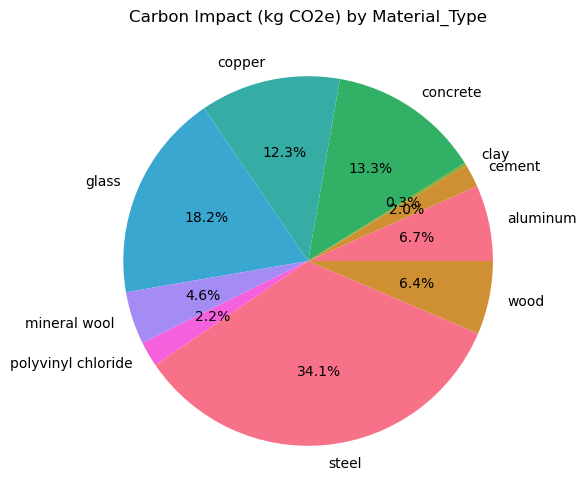

In [168]:
visualizer = LCAVisualizer()

# Plot carbon impact breakdown by material type
fig = visualizer.plot_impact_breakdown(impacts, 'carbon_impact', 'material_type')
plt.show()

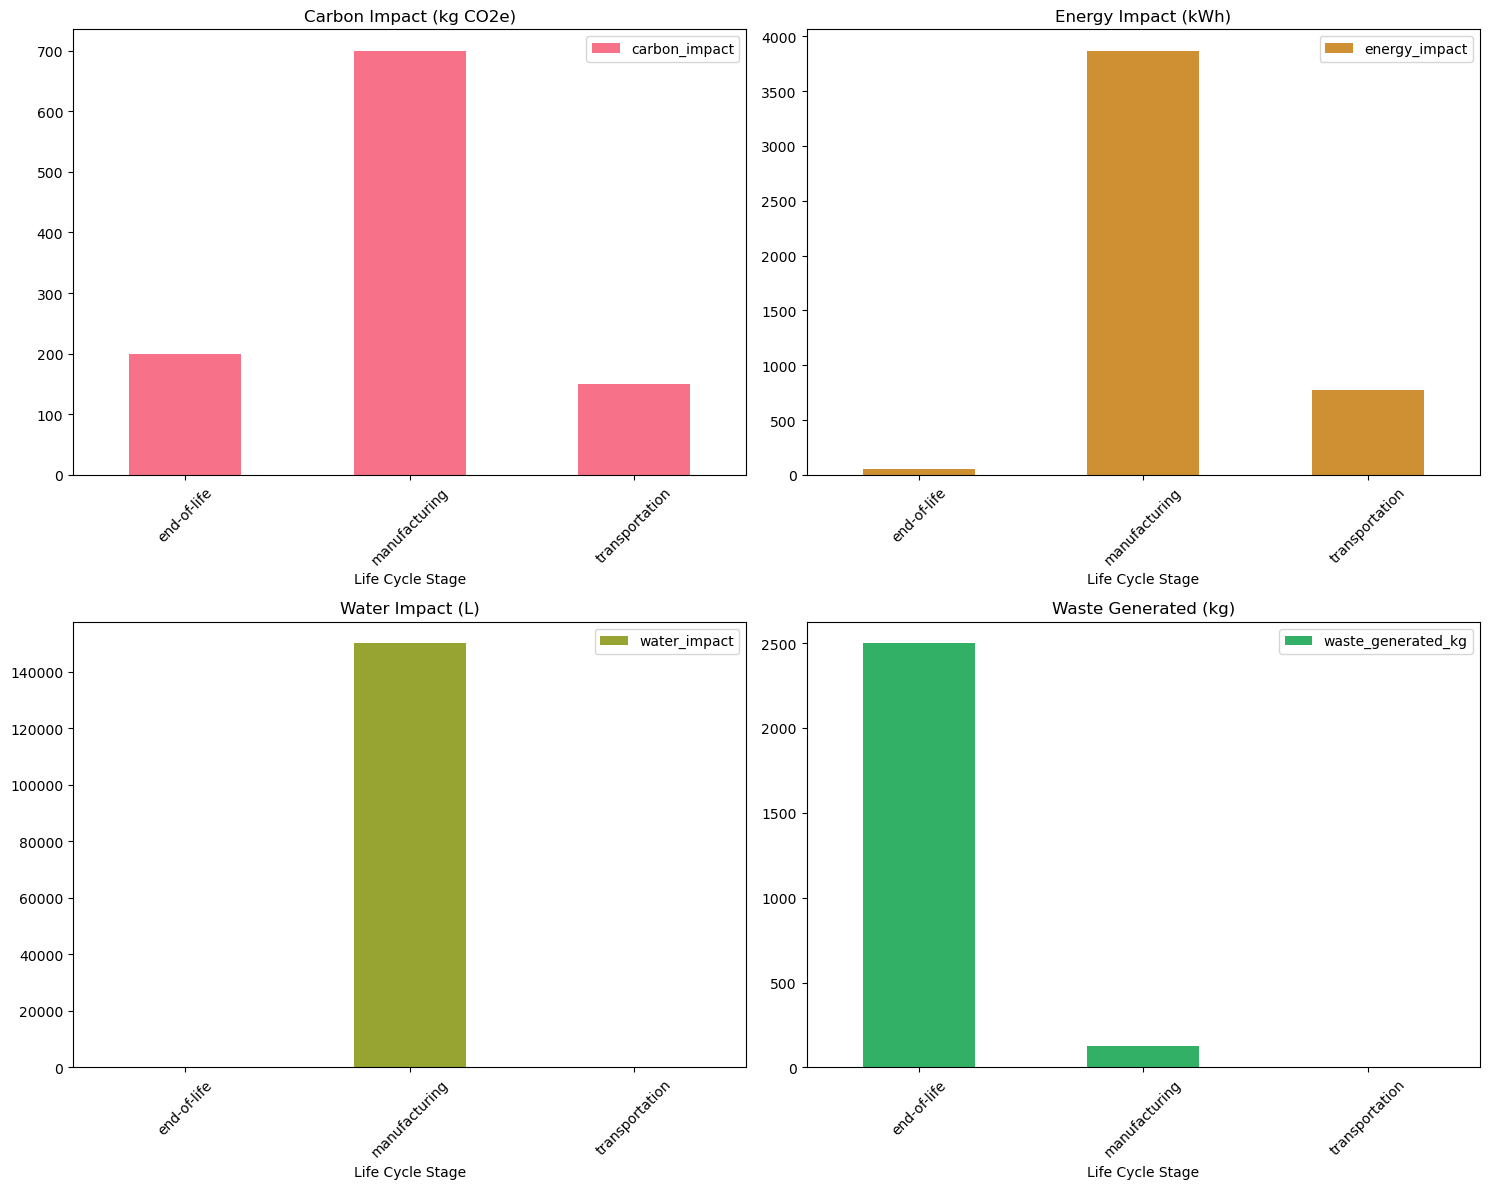

In [169]:
# Plot life cycle impacts for Product1
fig = visualizer.plot_life_cycle_impacts(impacts, 'P001')
plt.show()

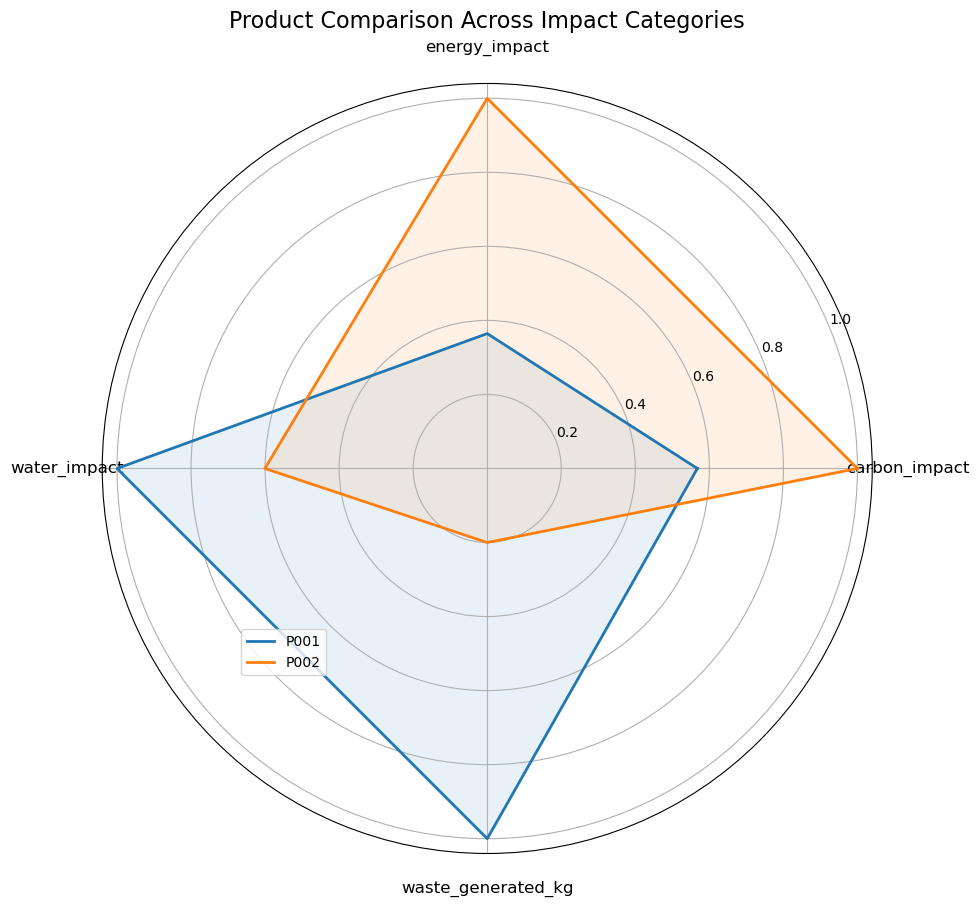

In [170]:
# Compare two products
fig = visualizer.plot_product_comparison(impacts, ['P001', 'P002'])
plt.show()

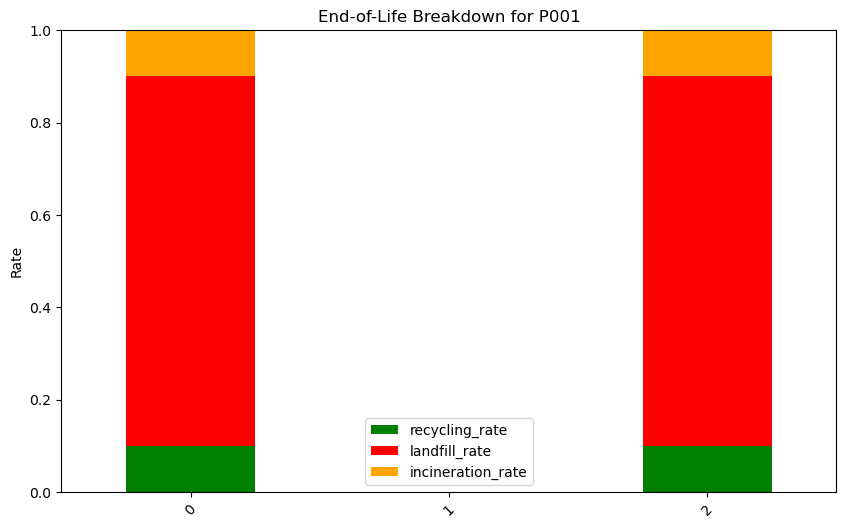

In [171]:
# Plot end-of-life breakdown for Product1
fig = visualizer.plot_end_of_life_breakdown(impacts, 'P001')
plt.show()

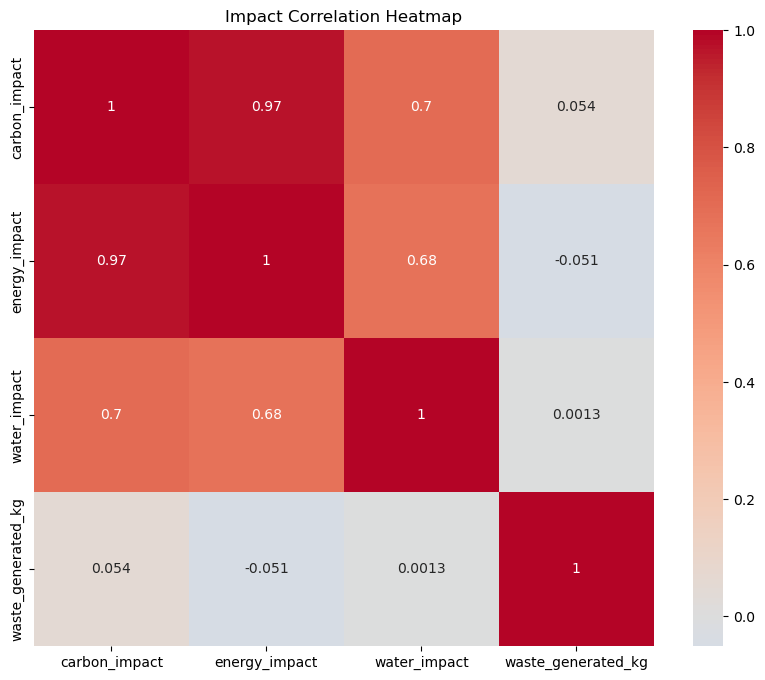

In [172]:
# Plot impact correlations
fig = visualizer.plot_impact_correlation(impacts)
plt.show()

In [173]:
# Normalize impacts for comparison
normalized_impacts = calculator.normalize_impacts(impacts)
print("Normalized Impacts:")
normalized_impacts.head()

Normalized Impacts:


,product_id,product_name,life_cycle_stage,material_type,quantity_kg,energy_consumption_kwh,transport_distance_km,waste_generated_kg,carbon_impact,energy_impact,water_impact,recycling_rate,landfill_rate,incineration_rate
0,P001,Reinforced Concrete,manufacturing,concrete,2500.0,120.0,50,125.0,0.518519,0.375728,1.000000,0.1,0.80,0.10
1,P001,Reinforced Concrete,transportation,concrete,2500.0,20.0,100,0.0,0.111111,0.074757,0.000000,0.0,0.00,0.00
2,P001,Reinforced Concrete,end-of-life,concrete,2500.0,50.0,30,2500.0,0.148148,0.004854,0.000333,0.1,0.80,0.10
3,P002,Structural Steel Beam,manufacturing,steel,500.0,300.0,200,25.0,1.000000,1.000000,0.500833,0.9,0.05,0.05
4,P002,Structural Steel Beam,transportation,steel,500.0,40.0,150,0.0,0.259259,0.246602,0.099900,0.0,0.00,0.00


In [174]:
# Compare alternative products
comparison = calculator.compare_alternatives(impacts, ['P001', 'P002'])
print("Product Comparison:")
comparison 

Product Comparison:


,product_id,product_name,carbon_impact,energy_impact,water_impact,waste_generated_kg
0,P001,Reinforced Concrete,1050.0,4690.0,150200.0,2625.0
1,P002,Structural Steel Beam,1850.0,12870.0,90230.0,525.0


In [175]:
!pip install openpyxl

import os
import pandas as pd

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Prepare file paths
excel_path = os.path.join(results_dir, 'LCA_outputs.xlsx')
csv_path = os.path.join(results_dir, 'summary_scores.csv')

# Create summary total score
summary = comparison.copy()
summary['total_score'] = (
    summary['carbon_impact'] + 
    summary['energy_impact'] + 
    summary['water_impact'] + 
    summary['waste_generated_kg']
)

# Save everything
try:
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        impacts.to_excel(writer, sheet_name='Calculated Impacts', index=False)
        normalized_impacts.to_excel(writer, sheet_name='Normalized Impacts', index=False)
        comparison.to_excel(writer, sheet_name='Product Comparison', index=False)
        summary.to_excel(writer, sheet_name='Summary Scores', index=False)

    summary[['product_id', 'product_name', 'total_score']].to_csv(csv_path, index=False)
    print(f"✅ Results saved to:\n- Excel: {excel_path}\n- CSV: {csv_path}")

except Exception as e:
    print(f"❌ Failed to save results: {e}")


✅ Results saved to:
- Excel: ../results/LCA_outputs.xlsx
- CSV: ../results/summary_scores.csv


In [176]:
# Create visualizer
visualizer = LCAVisualizer()

# 1. Impact Breakdown (carbon impact by material)
fig1 = visualizer.plot_impact_breakdown(impacts, 'carbon_impact', 'material_type')
fig1.savefig('../results/impact_breakdown.png', dpi=300)

# 2. Life Cycle Impacts for a product (e.g., P001)
fig2 = visualizer.plot_life_cycle_impacts(impacts, 'P001')
fig2.savefig('../results/life_cycle_impacts_P001.png', dpi=300)

# 3. Product Comparison Radar Chart (e.g., P001 vs P002)
fig3 = visualizer.plot_product_comparison(impacts, ['P001', 'P002'])
fig3.savefig('../results/product_comparison.png', dpi=300)

# 4. End-of-Life Breakdown (e.g., P001)
fig4 = visualizer.plot_end_of_life_breakdown(impacts, 'P001')
fig4.savefig('../results/end_of_life_P001.png', dpi=300)

# 5. Correlation Heatmap
fig5 = visualizer.plot_impact_correlation(impacts)
fig5.savefig('../results/impact_correlation.png', dpi=300)

plt.close('all')  # Close all figures after saving
print("✅ All visualizations saved to '../results/' folder as PNG files.")


✅ All visualizations saved to '../results/' folder as PNG files.


In [177]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

pdf_path = '../results/LCA_Report.pdf'

with PdfPages(pdf_path) as pdf:
    # Title Page
    fig_title = plt.figure(figsize=(11.69, 8.27))  # A4 landscape
    plt.text(0.5, 0.6, 'Life Cycle Assessment Report', fontsize=24, ha='center')
    plt.text(0.5, 0.5, 'Generated Automatically with Python', fontsize=14, ha='center')
    plt.axis('off')
    pdf.savefig(fig_title)
    plt.close()

    # Summary Table
    fig_summary, ax = plt.subplots(figsize=(11.69, 5))
    ax.axis('off')
    table_data = summary[['product_id', 'product_name', 'total_score']].round(2)
    table = ax.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     loc='center',
                     cellLoc='center')
    table.scale(1, 2)
    ax.set_title('Total Environmental Impact Scores by Product', fontsize=16, pad=20)
    pdf.savefig(fig_summary)
    plt.close()

    # Load and add each saved plot image
    image_paths = [
        '../results/impact_breakdown.png',
        '../results/life_cycle_impacts_P001.png',
        '../results/product_comparison.png',
        '../results/end_of_life_P001.png',
        '../results/impact_correlation.png'
    ]

    for path in image_paths:
        fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        pdf.savefig(fig)
        plt.close()

print(f"✅ PDF report created at: {pdf_path}")


✅ PDF report created at: ../results/LCA_Report.pdf
